## Correlation and Variance Inflation, Mode choice

This is a notebook to compute variance inflation factors and correlation coefficients between urban form and selected other features for models of mode choice in 19 European cities.

In general, we try to avoid VIF>5, and correlation factors > 0.7 (absolute value)

In [1]:
# load in required packages
import numpy as np
import pandas as pd
import geopandas as gpd
import shap
import re
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, GroupKFold, StratifiedGroupKFold, RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, linear_model
from xgboost import XGBClassifier, XGBRegressor
import statsmodels.formula.api as smf
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany']

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
def vif_corr(city):
    country=countries[cities_all.index(city)]
    print(city, country)
    if city=='Germany_other':
            city0='Dresden'
            df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
            df0['City']=city0
            df_all=df0.copy()

            cities=['Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
            for city1 in cities:
                df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
                df1['City']=city1
                if len(df1.columns==df_all.columns):
                    df_all=pd.concat([df_all,df1])
            df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
            df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(int).astype(str)
            df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(int).astype(str)
            df=df_all.copy()
    elif city=='France_other':
            city0='Clermont'
            df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
            df0.drop(columns=['IncomeDetailed', 'IncomeHarmonised','Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone', 'Sample','Sector_Zone', 'Zone','geo_unit','N_Stops', 'N_Legs'],errors='ignore',inplace=True)
            df0['City']=city0
            df_all=df0.copy()

            cities=['Toulouse','Montpellier','Lyon','Nantes','Nimes','Lille','Dijon']
            for city1 in cities:
                df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
                df1.drop(columns=['IncomeDetailed', 'IncomeHarmonised', 'Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone',  'Sample','Sector_Zone', 'Zone','geo_unit',
                                'Commune', 'Des_Cell', 'Grid_Cell', 'NoMobilityConstraints','Ori_Cell','N_Stops', 'N_Legs'],errors='ignore',inplace=True) # plus spme non-shared Paris variables
                #print(len(df1.columns), 'columns in the data for ', city1)
                df1['City']=city1
                if len(df1.columns==df_all.columns):
                    df1=df1[df_all.columns] # this is required for Paris, where the same columns exist after the dropping above, but the order is different
                    df_all=pd.concat([df_all,df1])
            df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(str)
            df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(str)
            df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(str)
            df=df_all.copy()
        
    else:
        df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')
    # here we limit to trips starting at home. therefore residential urban form features are same as origin features
    df['Start']=df['trip_type_all'].str[:4]
    df=df.loc[df['Start']=='Home',]
    if country=='Germany':
        df['TravelAlone']=1
        df.loc[(df['N_accomp_HH']>0),'TravelAlone']=0
        df=df.loc[df['Age']>=0,].copy()
        # extract the columns of interest for a trip distance  model. remove variables related to motorisation/equipment ownership
        df=df.loc[:,('HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
            'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
            #'TravelAlone',
            'HHSize', #'IncomeDetailed_Numeric', #'IncomeDetailed', 'HHType', # household details
            'Sex',  'Occupation', 'Education','Age', # 'MobilityConstraints',
            'UrbPopDensity_res','DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res',# 'MeanTime2Transit_res',
            'IntersecDensity_res', 'street_length_res','bike_lane_share_res','transit_accessibility_res', # 'diff', 'K_avg_res', 'StreetDensity_res', 'StreetsPerNode_res', 'K_avg_dest','StreetDensity_dest', 'StreetsPerNode_dest', 
            'LU_UrbFab_res','LU_Comm_res',    # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
            # target: mode
            'Mode')
            ]
    elif country=='France':
                # extract the columns of interest for a trip distance  model. remove variables related to motorisation/equipment ownership
        df=df.loc[:,('HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
            'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders, but remove n_others_car as it gives away the mode.     
            'HHSize', #'IncomeDetailed', # household details
            'Sex', 'Occupation', 'Education','Age', #'ParkingAvailable_Dest', # personal details, only use age for now, not age group, check later what works beter. missing 'MobilityConstraints' in FR
            'UrbPopDensity_res', 'DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res', # 'DistSubcenter_dest', 'DistCenter_dest', missing time2trans in FR
            'IntersecDensity_res', 'street_length_res', 'bike_lane_share_res','transit_accessibility_res',
            'LU_UrbFab_res','LU_Comm_res',   # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
            # target: mode
            'Mode')
            ]
        
    if city=='Wien':
        df=df.loc[:,('HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
        'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
        'HHSize', # 'IncomeDescriptiveNumeric', #'IncomeDetailed', 'HHType', # household details
        'Sex', 'Occupation', 'Education','Age', # 'ParkingAvailable_Dest', # personal details, only use age for now, not age group, check later what works beter
        'UrbPopDensity_res', 'DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res', # 'DistSubcenter_dest', 'DistCenter_dest', 'MeanTime2Transit_res',
        'IntersecDensity_res', 'street_length_res', 'bike_lane_share_res', 'transit_accessibility_res',# 'K_avg_res', 'StreetDensity_res', 'StreetsPerNode_res', 'K_avg_dest','StreetDensity_dest', 'StreetsPerNode_dest', 
        'LU_UrbFab_res','LU_Comm_res',     # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
        # target: mode
        'Mode')
        ]

    if city == 'Madrid':
        df=df.loc[:,('HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
        'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
        'HHSize', #'IncomeDetailed', 'HHType', # household details
        'Sex', 'Occupation', 'Education','Age', # personal details, only use age for now, not age group, check later what works beter
        'UrbPopDensity_res', 'DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res',
        'IntersecDensity_res', 'street_length_res', 'bike_lane_share_res','transit_accessibility_res',
        'LU_UrbFab_res','LU_Comm_res',    # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest', 'LU_Urban_res','LU_Urban_dest', 
        # target: Trip_Distance
        'Mode')
        ]

    df['Mode_num']=0
    # car, bike, foot, transit
    df.loc[df['Mode']=='Car','Mode_num']=0
    df.loc[df['Mode']=='Bike','Mode_num']=1
    df.loc[df['Mode']=='Foot','Mode_num']=2
    df.loc[df['Mode']=='Transit','Mode_num']=3

    df.drop(columns='Mode',inplace=True)

    df.loc[df['Education'].isin(['Secondary+BAC','Secondary+Matura']),'Education']='Secondary'

    # identify the feature columns
    N_non_feature=6 # how many non-features are at the start of the df
    cols=df.columns
    newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureM' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
    # change column names
    df.set_axis(newcols,axis=1,inplace=True)
    df = df.reset_index(drop=True)
    df.dropna(inplace=True)
    df0=df.copy()

    # convert  all categorical variables to dummies
    df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureM" in col]]
    for col in df_Cat:
        dum=pd.get_dummies(df[[col]])
        df = pd.concat([df, dum], axis = 1)
        # remove the original categorical columns
    df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
    # HPO with full dataset, grouping by individual person

    X=df[[col for col in df.columns if "FeatureM" in col]]
    return X

In [4]:
X=vif_corr('Berlin')
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Berlin Germany


Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


                      Feature         VIF
0                       const  212.222597
1           UrbPopDensity_res    4.131780
2           DistSubcenter_res    1.430201
3              DistCenter_res    3.887476
4         UrbBuildDensity_res    4.536508
5         IntersecDensity_res    3.031854
6           street_length_res    1.957834
7         bike_lane_share_res    1.172458
8   transit_accessibility_res    4.343128
9               LU_UrbFab_res    1.920435
10                LU_Comm_res    1.977680
11              Trip_Distance    1.036491


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.483,-0.672,0.773,0.620,-0.449,0.117,0.704,0.480,-0.040,-0.137
DistSubcenter_res,-0.483,1.000,0.453,-0.452,-0.329,0.185,-0.105,-0.464,-0.228,-0.166,0.101
DistCenter_res,-0.672,0.453,1.000,-0.751,-0.535,0.513,-0.301,-0.808,-0.164,-0.335,0.184
UrbBuildDensity_res,0.773,-0.452,-0.751,1.000,0.543,-0.467,0.258,0.800,0.268,0.320,-0.145
IntersecDensity_res,0.620,-0.329,-0.535,0.543,1.000,-0.659,0.053,0.602,0.559,-0.142,-0.126
street_length_res,-0.449,0.185,0.513,-0.467,-0.659,1.000,-0.143,-0.498,-0.302,-0.054,0.103
bike_lane_share_res,0.117,-0.105,-0.301,0.258,0.053,-0.143,1.000,0.278,-0.071,0.280,-0.054
transit_accessibility_res,0.704,-0.464,-0.808,0.800,0.602,-0.498,0.278,1.000,0.328,0.276,-0.156
LU_UrbFab_res,0.480,-0.228,-0.164,0.268,0.559,-0.302,-0.071,0.328,1.000,-0.376,-0.044
LU_Comm_res,-0.040,-0.166,-0.335,0.320,-0.142,-0.054,0.280,0.276,-0.376,1.000,-0.054


High-ish VIF for transit access, building density in Berlin. Also high correlations between population density and built-up density, and transit accessibility with built-up density. 

Dropping built-up density brings all VIF <4 and we just have two remaining correlation >0.7 (transit access and population density, 0.704, transit access and d2c, 0.808), but we keep these features out of interest to see their effects.

In [5]:
X.drop(columns='UrbBuildDensity_res',inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                      Feature         VIF
0                       const  212.166959
1           UrbPopDensity_res    2.955159
2           DistSubcenter_res    1.429419
3              DistCenter_res    3.877712
4         IntersecDensity_res    3.015800
5           street_length_res    1.955984
6         bike_lane_share_res    1.168626
7   transit_accessibility_res    3.927157
8               LU_UrbFab_res    1.916148
9                 LU_Comm_res    1.734486
10              Trip_Distance    1.036477


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.483,-0.672,0.620,-0.449,0.117,0.704,0.480,-0.040,-0.137
DistSubcenter_res,-0.483,1.000,0.453,-0.329,0.185,-0.105,-0.464,-0.228,-0.166,0.101
DistCenter_res,-0.672,0.453,1.000,-0.535,0.513,-0.301,-0.808,-0.164,-0.335,0.184
IntersecDensity_res,0.620,-0.329,-0.535,1.000,-0.659,0.053,0.602,0.559,-0.142,-0.126
street_length_res,-0.449,0.185,0.513,-0.659,1.000,-0.143,-0.498,-0.302,-0.054,0.103
bike_lane_share_res,0.117,-0.105,-0.301,0.053,-0.143,1.000,0.278,-0.071,0.280,-0.054
transit_accessibility_res,0.704,-0.464,-0.808,0.602,-0.498,0.278,1.000,0.328,0.276,-0.156
LU_UrbFab_res,0.480,-0.228,-0.164,0.559,-0.302,-0.071,0.328,1.000,-0.376,-0.044
LU_Comm_res,-0.040,-0.166,-0.335,-0.142,-0.054,0.280,0.276,-0.376,1.000,-0.054
Trip_Distance,-0.137,0.101,0.184,-0.126,0.103,-0.054,-0.156,-0.044,-0.054,1.000


In [10]:
X=vif_corr('Paris')
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Paris France
                      Feature         VIF
0                       const  406.893184
1           UrbPopDensity_res    6.166094
2           DistSubcenter_res    1.568392
3              DistCenter_res    4.509978
4         UrbBuildDensity_res    9.662456
5         IntersecDensity_res    4.599650
6           street_length_res    2.276487
7         bike_lane_share_res    4.128911
8   transit_accessibility_res   11.542073
9               LU_UrbFab_res    2.540125
10                LU_Comm_res    1.973770
11              Trip_Distance    1.017501


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.376,-0.769,0.812,0.686,-0.415,0.727,0.782,0.511,-0.307,-0.088
DistSubcenter_res,-0.376,1.000,0.541,-0.452,-0.407,0.099,-0.345,-0.408,-0.118,-0.044,0.091
DistCenter_res,-0.769,0.541,1.000,-0.773,-0.633,0.270,-0.726,-0.803,-0.295,0.110,0.122
UrbBuildDensity_res,0.812,-0.452,-0.773,1.000,0.565,-0.273,0.704,0.892,0.271,-0.035,-0.094
IntersecDensity_res,0.686,-0.407,-0.633,0.565,1.000,-0.654,0.514,0.659,0.603,-0.332,-0.073
street_length_res,-0.415,0.099,0.270,-0.273,-0.654,1.000,-0.380,-0.393,-0.343,0.385,0.008
bike_lane_share_res,0.727,-0.345,-0.726,0.704,0.514,-0.380,1.000,0.824,0.283,-0.251,-0.073
transit_accessibility_res,0.782,-0.408,-0.803,0.892,0.659,-0.393,0.824,1.000,0.388,-0.228,-0.095
LU_UrbFab_res,0.511,-0.118,-0.295,0.271,0.603,-0.343,0.283,0.388,1.000,-0.578,-0.027
LU_Comm_res,-0.307,-0.044,0.110,-0.035,-0.332,0.385,-0.251,-0.228,-0.578,1.000,-0.009


In Paris, we have problematic VIFs with transit accessibility and built-up density, which are highlt correlated (0.892)
There is also problematic correlation between transit accessibility and bike lane share (0.824), but we want to see the influence of both of these features.
So we just drop built-up density, and note the remaining high correlation in the manuscript.
This brings VIFs into just-about acceptable range. 5 for transit access, 4.5 for distance to center and intersection density.

In [11]:
X.drop(columns='UrbBuildDensity_res',inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                      Feature         VIF
0                       const  406.869657
1           UrbPopDensity_res    3.898890
2           DistSubcenter_res    1.517708
3              DistCenter_res    4.481637
4         IntersecDensity_res    4.526139
5           street_length_res    2.271006
6         bike_lane_share_res    3.759663
7   transit_accessibility_res    5.008027
8               LU_UrbFab_res    2.479594
9                 LU_Comm_res    1.727921
10              Trip_Distance    1.017242


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.376,-0.769,0.686,-0.415,0.727,0.782,0.511,-0.307,-0.088
DistSubcenter_res,-0.376,1.000,0.541,-0.407,0.099,-0.345,-0.408,-0.118,-0.044,0.091
DistCenter_res,-0.769,0.541,1.000,-0.633,0.270,-0.726,-0.803,-0.295,0.110,0.122
IntersecDensity_res,0.686,-0.407,-0.633,1.000,-0.654,0.514,0.659,0.603,-0.332,-0.073
street_length_res,-0.415,0.099,0.270,-0.654,1.000,-0.380,-0.393,-0.343,0.385,0.008
bike_lane_share_res,0.727,-0.345,-0.726,0.514,-0.380,1.000,0.824,0.283,-0.251,-0.073
transit_accessibility_res,0.782,-0.408,-0.803,0.659,-0.393,0.824,1.000,0.388,-0.228,-0.095
LU_UrbFab_res,0.511,-0.118,-0.295,0.603,-0.343,0.283,0.388,1.000,-0.578,-0.027
LU_Comm_res,-0.307,-0.044,0.110,-0.332,0.385,-0.251,-0.228,-0.578,1.000,-0.009
Trip_Distance,-0.088,0.091,0.122,-0.073,0.008,-0.073,-0.095,-0.027,-0.009,1.000


In [12]:
X=vif_corr('Madrid')
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Madrid Spain


Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.


                      Feature         VIF
0                       const  203.710928
1           UrbPopDensity_res    2.545391
2           DistSubcenter_res    1.306149
3              DistCenter_res    2.592400
4         UrbBuildDensity_res    1.189968
5         IntersecDensity_res    2.792999
6           street_length_res    2.145432
7         bike_lane_share_res    1.270644
8   transit_accessibility_res    3.491849
9               LU_UrbFab_res    2.145681
10                LU_Comm_res    1.397639
11              Trip_Distance    1.039448


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.363,-0.264,0.197,0.518,-0.408,0.135,0.514,0.647,-0.158,-0.110
DistSubcenter_res,-0.363,1.000,0.169,-0.190,-0.292,0.284,-0.088,-0.193,-0.135,-0.159,0.107
DistCenter_res,-0.264,0.169,1.000,-0.271,-0.412,0.024,-0.278,-0.729,-0.193,0.087,0.166
UrbBuildDensity_res,0.197,-0.190,-0.271,1.000,0.010,-0.002,0.055,0.213,0.181,-0.065,-0.055
IntersecDensity_res,0.518,-0.292,-0.412,0.010,1.000,-0.632,0.061,0.490,0.364,-0.075,-0.126
street_length_res,-0.408,0.284,0.024,-0.002,-0.632,1.000,-0.031,-0.137,-0.245,-0.119,0.073
bike_lane_share_res,0.135,-0.088,-0.278,0.055,0.061,-0.031,1.000,0.394,0.015,0.036,-0.055
transit_accessibility_res,0.514,-0.193,-0.729,0.213,0.490,-0.137,0.394,1.000,0.393,-0.028,-0.157
LU_UrbFab_res,0.647,-0.135,-0.193,0.181,0.364,-0.245,0.015,0.393,1.000,-0.389,-0.075
LU_Comm_res,-0.158,-0.159,0.087,-0.065,-0.075,-0.119,0.036,-0.028,-0.389,1.000,-0.006


Acceptable VIFs in Madrid. Just one high correlation, between transit access and distance to center (0.729).

In [13]:
X=vif_corr('Wien')
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Wien Austria
                      Feature         VIF
0                       const  340.233340
1           UrbPopDensity_res    7.022443
2           DistSubcenter_res    2.550451
3              DistCenter_res    5.042951
4         UrbBuildDensity_res    6.267251
5         IntersecDensity_res    8.613386
6           street_length_res    5.841137
7         bike_lane_share_res    3.763517
8   transit_accessibility_res   10.293589
9               LU_UrbFab_res    7.495368
10                LU_Comm_res    2.061902
11              Trip_Distance    1.043446


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.191,-0.742,0.625,0.741,-0.631,0.664,0.850,0.820,0.030,-0.172
DistSubcenter_res,-0.191,1.000,0.512,-0.351,-0.252,0.191,-0.345,-0.275,-0.368,-0.278,0.094
DistCenter_res,-0.742,0.512,1.000,-0.694,-0.613,0.525,-0.601,-0.772,-0.589,-0.213,0.188
UrbBuildDensity_res,0.625,-0.351,-0.694,1.000,0.533,-0.407,0.766,0.816,0.494,0.447,-0.147
IntersecDensity_res,0.741,-0.252,-0.613,0.533,1.000,-0.897,0.608,0.701,0.780,-0.160,-0.170
street_length_res,-0.631,0.191,0.525,-0.407,-0.897,1.000,-0.448,-0.568,-0.694,0.191,0.147
bike_lane_share_res,0.664,-0.345,-0.601,0.766,0.608,-0.448,1.000,0.771,0.658,0.130,-0.143
transit_accessibility_res,0.850,-0.275,-0.772,0.816,0.701,-0.568,0.771,1.000,0.774,0.251,-0.178
LU_UrbFab_res,0.820,-0.368,-0.589,0.494,0.780,-0.694,0.658,0.774,1.000,-0.023,-0.162
LU_Comm_res,0.030,-0.278,-0.213,0.447,-0.160,0.191,0.130,0.251,-0.023,1.000,-0.041


Unacceptable correlations in Vienna, especially, but not only, between pop density and transit accessibility

<AxesSubplot:xlabel='UrbPopDensity_res', ylabel='transit_accessibility_res'>

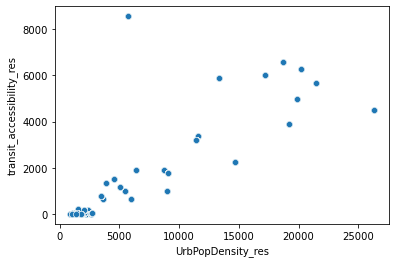

In [14]:
sns.scatterplot(data=X, x="UrbPopDensity_res", y="transit_accessibility_res")

Dropping built-up density, intersection density, urban fabric land use, and transit accessibility brings VIFs down, and deals with all but one of the high correlations, distance to center and population density (0.742)

In [11]:
X=vif_corr('Wien')
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X.drop(columns=['UrbBuildDensity_res','IntersecDensity_res','LU_UrbFab_res','transit_accessibility_res'],inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Wien Austria
               Feature        VIF
0                const  81.260029
1    UrbPopDensity_res   3.622896
2    DistSubcenter_res   1.632427
3       DistCenter_res   3.415466
4    street_length_res   1.892200
5  bike_lane_share_res   1.981630
6          LU_Comm_res   1.253628
7        Trip_Distance   1.041793


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,street_length_res,bike_lane_share_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.191,-0.742,-0.631,0.664,0.030,-0.172
DistSubcenter_res,-0.191,1.000,0.512,0.191,-0.345,-0.278,0.094
DistCenter_res,-0.742,0.512,1.000,0.525,-0.601,-0.213,0.188
street_length_res,-0.631,0.191,0.525,1.000,-0.448,0.191,0.147
bike_lane_share_res,0.664,-0.345,-0.601,-0.448,1.000,0.130,-0.143
LU_Comm_res,0.030,-0.278,-0.213,0.191,0.130,1.000,-0.041
Trip_Distance,-0.172,0.094,0.188,0.147,-0.143,-0.041,1.000


In [15]:
X=vif_corr('Germany_other')
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Germany_other Germany


Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.


                      Feature         VIF
0                       const  156.506793
1           UrbPopDensity_res    3.245768
2           DistSubcenter_res    1.308215
3              DistCenter_res    1.733465
4         UrbBuildDensity_res    1.289271
5         IntersecDensity_res    3.947504
6           street_length_res    1.984550
7         bike_lane_share_res    1.305407
8   transit_accessibility_res    3.295317
9               LU_UrbFab_res    3.419172
10                LU_Comm_res    1.401782
11              Trip_Distance    1.009982


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.148,-0.355,0.170,0.682,-0.492,0.278,0.710,0.767,0.066,-0.036
DistSubcenter_res,-0.148,1.000,0.263,-0.237,-0.162,0.114,-0.282,-0.137,-0.078,-0.300,0.037
DistCenter_res,-0.355,0.263,1.000,-0.118,-0.530,0.287,-0.264,-0.544,-0.331,-0.240,0.087
UrbBuildDensity_res,0.170,-0.237,-0.118,1.000,0.065,0.148,0.018,0.247,0.086,0.277,-0.020
IntersecDensity_res,0.682,-0.162,-0.530,0.065,1.000,-0.658,0.349,0.664,0.737,0.062,-0.059
street_length_res,-0.492,0.114,0.287,0.148,-0.658,1.000,-0.301,-0.436,-0.483,-0.053,0.039
bike_lane_share_res,0.278,-0.282,-0.264,0.018,0.349,-0.301,1.000,0.281,0.153,0.054,-0.041
transit_accessibility_res,0.710,-0.137,-0.544,0.247,0.664,-0.436,0.281,1.000,0.655,0.322,-0.067
LU_UrbFab_res,0.767,-0.078,-0.331,0.086,0.737,-0.483,0.153,0.655,1.000,0.015,-0.053
LU_Comm_res,0.066,-0.300,-0.240,0.277,0.062,-0.053,0.054,0.322,0.015,1.000,-0.039


Rest of Germany has acceptable VIFs, intersection density is highest (3.9). A few high correlations involving pop density with transit access, land-use urban fabric, and intersection density with land-use urban fabric.
Dropping intersection density removes the highest VIF, and some source of correlation. It also maintains consistency with rest of France.

In [16]:
X.drop(columns='IntersecDensity_res',inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                      Feature        VIF
0                       const  96.129575
1           UrbPopDensity_res   3.237033
2           DistSubcenter_res   1.308211
3              DistCenter_res   1.531410
4         UrbBuildDensity_res   1.284234
5           street_length_res   1.583567
6         bike_lane_share_res   1.269221
7   transit_accessibility_res   3.257662
8               LU_UrbFab_res   2.814122
9                 LU_Comm_res   1.385554
10              Trip_Distance   1.009924


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.148,-0.355,0.170,-0.492,0.278,0.710,0.767,0.066,-0.036
DistSubcenter_res,-0.148,1.000,0.263,-0.237,0.114,-0.282,-0.137,-0.078,-0.300,0.037
DistCenter_res,-0.355,0.263,1.000,-0.118,0.287,-0.264,-0.544,-0.331,-0.240,0.087
UrbBuildDensity_res,0.170,-0.237,-0.118,1.000,0.148,0.018,0.247,0.086,0.277,-0.020
street_length_res,-0.492,0.114,0.287,0.148,1.000,-0.301,-0.436,-0.483,-0.053,0.039
bike_lane_share_res,0.278,-0.282,-0.264,0.018,-0.301,1.000,0.281,0.153,0.054,-0.041
transit_accessibility_res,0.710,-0.137,-0.544,0.247,-0.436,0.281,1.000,0.655,0.322,-0.067
LU_UrbFab_res,0.767,-0.078,-0.331,0.086,-0.483,0.153,0.655,1.000,0.015,-0.053
LU_Comm_res,0.066,-0.300,-0.240,0.277,-0.053,0.054,0.322,0.015,1.000,-0.039
Trip_Distance,-0.036,0.037,0.087,-0.020,0.039,-0.041,-0.067,-0.053,-0.039,1.000


In [17]:
X=vif_corr('France_other')
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

France_other France
                      Feature         VIF
0                       const  100.200453
1           UrbPopDensity_res    3.694094
2           DistSubcenter_res    1.549643
3              DistCenter_res    1.970607
4         UrbBuildDensity_res    3.430516
5         IntersecDensity_res    4.065499
6           street_length_res    1.903100
7         bike_lane_share_res    1.570709
8   transit_accessibility_res    4.931646
9               LU_UrbFab_res    1.985385
10                LU_Comm_res    1.371300
11              Trip_Distance    1.070890


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.324,-0.463,0.696,0.661,-0.311,0.207,0.757,0.530,-0.012,-0.165
DistSubcenter_res,-0.324,1.000,0.503,-0.325,-0.470,0.375,-0.205,-0.361,-0.275,-0.271,0.160
DistCenter_res,-0.463,0.503,1.000,-0.422,-0.611,0.368,-0.310,-0.583,-0.320,-0.182,0.222
UrbBuildDensity_res,0.696,-0.325,-0.422,1.000,0.608,-0.265,0.209,0.748,0.157,0.281,-0.140
IntersecDensity_res,0.661,-0.470,-0.611,0.608,1.000,-0.643,0.292,0.696,0.511,0.130,-0.222
street_length_res,-0.311,0.375,0.368,-0.265,-0.643,1.000,-0.297,-0.364,-0.325,-0.085,0.166
bike_lane_share_res,0.207,-0.205,-0.310,0.209,0.292,-0.297,1.000,0.492,0.133,0.131,-0.073
transit_accessibility_res,0.757,-0.361,-0.583,0.748,0.696,-0.364,0.492,1.000,0.376,0.162,-0.162
LU_UrbFab_res,0.530,-0.275,-0.320,0.157,0.511,-0.325,0.133,0.376,1.000,-0.245,-0.129
LU_Comm_res,-0.012,-0.271,-0.182,0.281,0.130,-0.085,0.131,0.162,-0.245,1.000,-0.076


High VIF (4.9) for transit access and intersection density (4.0). Dropping intersection density helps bring down some high VIF, and keeps consistency with rest of Germany.
Still have high correlations between transit access with population density and built-up densityh

In [15]:
X.drop(columns='IntersecDensity_res',inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                      Feature        VIF
0                       const  57.934168
1           UrbPopDensity_res   3.667413
2           DistSubcenter_res   1.545136
3              DistCenter_res   1.845233
4         UrbBuildDensity_res   3.260153
5           street_length_res   1.351475
6         bike_lane_share_res   1.557214
7   transit_accessibility_res   4.798317
8               LU_UrbFab_res   1.833684
9                 LU_Comm_res   1.368700
10              Trip_Distance   1.068792


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.324,-0.463,0.696,-0.311,0.207,0.757,0.530,-0.012,-0.165
DistSubcenter_res,-0.324,1.000,0.503,-0.325,0.375,-0.205,-0.361,-0.275,-0.271,0.160
DistCenter_res,-0.463,0.503,1.000,-0.422,0.368,-0.310,-0.583,-0.320,-0.182,0.222
UrbBuildDensity_res,0.696,-0.325,-0.422,1.000,-0.265,0.209,0.748,0.157,0.281,-0.140
street_length_res,-0.311,0.375,0.368,-0.265,1.000,-0.297,-0.364,-0.325,-0.085,0.166
bike_lane_share_res,0.207,-0.205,-0.310,0.209,-0.297,1.000,0.492,0.133,0.131,-0.073
transit_accessibility_res,0.757,-0.361,-0.583,0.748,-0.364,0.492,1.000,0.376,0.162,-0.162
LU_UrbFab_res,0.530,-0.275,-0.320,0.157,-0.325,0.133,0.376,1.000,-0.245,-0.129
LU_Comm_res,-0.012,-0.271,-0.182,0.281,-0.085,0.131,0.162,-0.245,1.000,-0.076
Trip_Distance,-0.165,0.160,0.222,-0.140,0.166,-0.073,-0.162,-0.129,-0.076,1.000


In [ ]:
# Check for all cities

In [18]:
city0='Berlin'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
print(len(df0.columns), 'columns in the data for ', city0)
df0['City']=city0
df_all=df0.copy()

cities=['Dresden','Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
for city1 in cities:
    print(city1)
    df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
    print(len(df1.columns), 'columns in the data for ', city1)
    df1['City']=city1
    if len(df1.columns==df_all.columns):
        df_all=pd.concat([df_all,df1])
        print(city1, 'added.')
        print(len(df_all), 'rows in the combined dataframe')
df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(int).astype(str)
df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(int).astype(str)
df_DE=df_all.copy()
df_DE['Start']=df_DE['trip_type_all'].str[:4]
df_DE=df_DE.loc[df_DE['Start']=='Home',]
df_DE['Country']='Germany'

df_DE=df_DE.loc[:,('City', 'HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
    'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
    'HHSize', #'IncomeDetailed_Numeric', #'IncomeDetailed', 'HHType', # household details
    'Sex',  'Occupation', 'Education','Age', # 'MobilityConstraints',
    'UrbPopDensity_res','DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res',# 'MeanTime2Transit_res',
    'IntersecDensity_res', 'street_length_res','bike_lane_share_res', 'transit_accessibility_res',# 'diff', 'K_avg_res', 'StreetDensity_res', 'StreetsPerNode_res', 'K_avg_dest','StreetDensity_dest', 'StreetsPerNode_dest', 
    'LU_UrbFab_res','LU_Comm_res','Country',# urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
    # target: mode
    'Mode')
    ]
city0='Clermont'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
df0.drop(columns=['IncomeDetailed', 'IncomeHarmonised','Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone', 'Sample','Sector_Zone', 'Zone','geo_unit','N_Stops', 'N_Legs'],errors='ignore',inplace=True)
print(len(df0.columns), 'columns in the data for ', city0)
df0['City']=city0
df_all=df0.copy()

cities=['Toulouse','Montpellier','Lyon','Nantes','Nimes','Lille','Dijon']
for city1 in cities:
    print(city1)
    df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
    df1.drop(columns=['IncomeDetailed', 'IncomeHarmonised', 'Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone',  'Sample','Sector_Zone', 'Zone','geo_unit',
                    'Commune', 'Des_Cell', 'Grid_Cell', 'NoMobilityConstraints','Ori_Cell','N_Stops', 'N_Legs'],errors='ignore',inplace=True) # plus spme non-shared Paris variables
    print(len(df1.columns), 'columns in the data for ', city1)
    df1['City']=city1
    if len(df1.columns==df_all.columns):
        df1=df1[df_all.columns] # this is required for Paris, where the same columns exist after the dropping above, but the order is different
        df_all=pd.concat([df_all,df1])
        print(city1, 'added.')
        print(len(df_all), 'rows in the combined dataframe')
df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(str)
df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(str)
df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(str)
df_FR=df_all.copy()
df_FR['Start']=df_FR['trip_type_all'].str[:4]
df_FR=df_FR.loc[df_FR['Start']=='Home',]
df_FR['Country']='France'
df_FR=df_FR.loc[:,('City','HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
    'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
    'HHSize', #'IncomeDetailed_Numeric', #'IncomeDetailed', 'HHType', # household details
    'Sex',  'Occupation', 'Education','Age', # 'MobilityConstraints',
    'UrbPopDensity_res','DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res',# 'MeanTime2Transit_res',
    'IntersecDensity_res', 'street_length_res','bike_lane_share_res','transit_accessibility_res', # 'diff', 'K_avg_res', 'StreetDensity_res', 'StreetsPerNode_res', 'K_avg_dest','StreetDensity_dest', 'StreetsPerNode_dest', 
    'LU_UrbFab_res','LU_Comm_res', 'Country',  # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
    # target: mode
    'Mode')
    ]
city='Paris'
df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')
df['City']=city
df['Country']='France'
df['HHNR']=df['City']+'_'+df['HHNR'].astype(str)
df['HH_PNR']=df['City']+'_'+df['HH_PNR'].astype(str)
df['HH_P_WNR']=df['City']+'_'+df['HH_P_WNR'].astype(str)
df['Start']=df['trip_type_all'].str[:4]
df=df.loc[df['Start']=='Home',]

df_Paris=df.copy()
df_Paris=df_Paris.loc[:,('City','HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
    'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
    'HHSize', #'IncomeDetailed_Numeric', #'IncomeDetailed', 'HHType', # household details
    'Sex',  'Occupation', 'Education','Age', # 'MobilityConstraints',
    'UrbPopDensity_res','DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res',# 'MeanTime2Transit_res',
    'IntersecDensity_res', 'street_length_res','bike_lane_share_res','transit_accessibility_res', # 'diff', 'K_avg_res', 'StreetDensity_res', 'StreetsPerNode_res', 'K_avg_dest','StreetDensity_dest', 'StreetsPerNode_dest', 
    'LU_UrbFab_res','LU_Comm_res', 'Country',  # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
    # target: mode
    'Mode')
    ]
city='Madrid'
df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')
df['City']=city
df['Country']='Spain'
df['HHNR']=df['City']+'_'+df['HHNR'].astype(str)
df['HH_PNR']=df['City']+'_'+df['HH_PNR'].astype(str)
df['HH_P_WNR']=df['City']+'_'+df['HH_P_WNR'].astype(str)
df['Start']=df['trip_type_all'].str[:4]
df=df.loc[df['Start']=='Home',]

df_Madrid=df.copy()
df_Madrid=df_Madrid.loc[:,('City','HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
    'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
    'HHSize', #'IncomeDetailed_Numeric', #'IncomeDetailed', 'HHType', # household details
    'Sex',  'Occupation', 'Education','Age', # 'MobilityConstraints',
    'UrbPopDensity_res','DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res',# 'MeanTime2Transit_res',
    'IntersecDensity_res', 'street_length_res','bike_lane_share_res','transit_accessibility_res', # 'diff', 'K_avg_res', 'StreetDensity_res', 'StreetsPerNode_res', 'K_avg_dest','StreetDensity_dest', 'StreetsPerNode_dest', 
    'LU_UrbFab_res','LU_Comm_res','Country',   # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
    # target: mode
    'Mode')
    ]
city='Wien'
df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')
df['City']=city
df['Country']='Austria'
df['HHNR']=df['City']+'_'+df['HHNR'].astype(str)
df['HH_PNR']=df['City']+'_'+df['HH_PNR'].astype(str)
df['HH_P_WNR']=df['City']+'_'+df['HH_P_WNR'].astype(str)
df['Start']=df['trip_type_all'].str[:4]
df=df.loc[df['Start']=='Home',]

df_Wien=df.copy()
df_Wien=df_Wien.loc[:,('City','HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
    'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
    'HHSize', #'IncomeDetailed_Numeric', #'IncomeDetailed', 'HHType', # household details
    'Sex',  'Occupation', 'Education','Age', # 'MobilityConstraints',
    'UrbPopDensity_res','DistSubcenter_res', 'DistCenter_res','UrbBuildDensity_res',# 'MeanTime2Transit_res',
    'IntersecDensity_res', 'street_length_res','bike_lane_share_res','transit_accessibility_res', # 'diff', 'K_avg_res', 'StreetDensity_res', 'StreetsPerNode_res', 'K_avg_dest','StreetDensity_dest', 'StreetsPerNode_dest', 
    'LU_UrbFab_res','LU_Comm_res','Country',   # urban form features, land-use features are now all from UA. removed 'LU_Road_res', 'LU_Road_dest',
    # target: mode
    'Mode')
    ]
df=pd.concat([df_DE,df_FR,df_Paris,df_Madrid,df_Wien],ignore_index=True)

Occ_dict={'Employed_FullTime':'Employed','Employed_PartTime':'Employed','Employed':'Employed','Trainee':'Employed',
          'Student_School':'Student_School','Student_3rdLevel':'Student_3rdLevel','Pre-School':'Pre-School','Retired':'Retired',
          'Unemployed':'Unemployed/Other','Other':'Unemployed/Other','Home_Partner':'Unemployed/Other'}
Edu_dict={'University':'University','Secondary':'Secondary','Secondary+BAC':'Secondary','Secondary+Matura':'Secondary',
          'Apprenticeship':'Apprenticeship',
          'Elementary':'Primary/None','Pre-School':'Primary/None','No diploma yet':'Primary/None','Unknown':'Primary/None','Other':'Primary/None'}

df['Occupation']=df['Occupation'].map(Occ_dict)
df['Education']=df['Education'].map(Edu_dict)
df['Mode_num']=0
# car, bike, foot, transit
df.loc[df['Mode']=='Car','Mode_num']=0
df.loc[df['Mode']=='Bike','Mode_num']=1
df.loc[df['Mode']=='Foot','Mode_num']=2
df.loc[df['Mode']=='Transit','Mode_num']=3

df.drop(columns='Mode',inplace=True)
# identify the feature columns
N_non_feature=7 # how many non-features are at the start of the df
cols=df.columns
newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureM' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
# change column names
df.set_axis(newcols,axis=1,inplace=True)
df = df.reset_index(drop=True)
df.dropna(inplace=True)
df0=df.copy()

# convert  all categorical variables to dummies
df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureM" in col]]
for col in df_Cat:
    dum=pd.get_dummies(df[[col]])
    df = pd.concat([df, dum], axis = 1)
    # remove the original categorical columns
df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
# HPO with full dataset, grouping by individual person
target = 'Mode_num'
X=df[[col for col in df.columns if "FeatureM" in col]]

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


77 columns in the data for  Berlin
Dresden
77 columns in the data for  Dresden
Dresden added.
126573 rows in the combined dataframe
Leipzig
77 columns in the data for  Leipzig
Leipzig added.
138169 rows in the combined dataframe
Magdeburg
77 columns in the data for  Magdeburg
Magdeburg added.
147545 rows in the combined dataframe
Potsdam
77 columns in the data for  Potsdam
Potsdam added.
153368 rows in the combined dataframe
Frankfurt am Main
77 columns in the data for  Frankfurt am Main
Frankfurt am Main added.
159403 rows in the combined dataframe
Düsseldorf
77 columns in the data for  Düsseldorf
Düsseldorf added.
183247 rows in the combined dataframe
Kassel


Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.


77 columns in the data for  Kassel
Kassel added.
192614 rows in the combined dataframe
58 columns in the data for  Clermont
Toulouse
58 columns in the data for  Toulouse
Toulouse added.
49864 rows in the combined dataframe
Montpellier
58 columns in the data for  Montpellier
Montpellier added.
80127 rows in the combined dataframe
Lyon
58 columns in the data for  Lyon
Lyon added.
132884 rows in the combined dataframe
Nantes
58 columns in the data for  Nantes
Nantes added.
167926 rows in the combined dataframe
Nimes
58 columns in the data for  Nimes
Nimes added.
179143 rows in the combined dataframe
Lille
58 columns in the data for  Lille
Lille added.
215992 rows in the combined dataframe
Dijon
58 columns in the data for  Dijon
Dijon added.
230246 rows in the combined dataframe


Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.


No correlation concerns with all cities

In [17]:
X_disp=[re.sub('FeatureM_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity_res','DistSubcenter_res','DistCenter_res','UrbBuildDensity_res','IntersecDensity_res','street_length_res','bike_lane_share_res','transit_accessibility_res','LU_UrbFab_res','LU_Comm_res','Trip_Distance']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                      Feature         VIF
0                       const  103.511492
1           UrbPopDensity_res    3.237553
2           DistSubcenter_res    1.282384
3              DistCenter_res    1.557388
4         UrbBuildDensity_res    1.268584
5         IntersecDensity_res    3.528788
6           street_length_res    2.384996
7         bike_lane_share_res    1.178000
8   transit_accessibility_res    2.874851
9               LU_UrbFab_res    1.530739
10                LU_Comm_res    1.194109
11              Trip_Distance    1.040451


,UrbPopDensity_res,DistSubcenter_res,DistCenter_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,bike_lane_share_res,transit_accessibility_res,LU_UrbFab_res,LU_Comm_res,Trip_Distance
UrbPopDensity_res,1.000,-0.307,-0.121,0.413,0.639,-0.414,-0.004,0.711,0.510,-0.102,-0.101
DistSubcenter_res,-0.307,1.000,0.294,-0.209,-0.281,0.168,-0.125,-0.258,-0.179,-0.181,0.099
DistCenter_res,-0.121,0.294,1.000,-0.173,-0.239,0.113,-0.348,-0.412,-0.140,-0.084,0.148
UrbBuildDensity_res,0.413,-0.209,-0.173,1.000,0.282,-0.196,0.003,0.403,0.170,0.023,-0.058
IntersecDensity_res,0.639,-0.281,-0.239,0.282,1.000,-0.737,0.047,0.553,0.434,-0.031,-0.140
street_length_res,-0.414,0.168,0.113,-0.196,-0.737,1.000,-0.072,-0.272,-0.278,-0.016,0.117
bike_lane_share_res,-0.004,-0.125,-0.348,0.003,0.047,-0.072,1.000,0.156,0.070,0.090,-0.055
transit_accessibility_res,0.711,-0.258,-0.412,0.403,0.553,-0.272,0.156,1.000,0.381,0.031,-0.119
LU_UrbFab_res,0.510,-0.179,-0.140,0.170,0.434,-0.278,0.070,0.381,1.000,-0.275,-0.090
LU_Comm_res,-0.102,-0.181,-0.084,0.023,-0.031,-0.016,0.090,0.031,-0.275,1.000,-0.049
